In [16]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import sample as sm
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import torch
import wasserstein_torch as w2
from joblib import Parallel, delayed
import csv

repo = '..'

L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))
L0, L1, D, D_r = 0.4, 3.5, 3, 300
sampler = sm.MatrixSampler(L0, L1, train.T)
training_points = 20000
N_max = train.shape[1]
beta = 4e-5
n_w2 = 1000
n_reps = 10
n_attr = 1000
# attractor = torch.tensor(train[:, np.random.choice(N_max, n_w2, replace=False)].T, dtype=torch.float32)
attractor = torch.tensor(train[:, :n_w2].T, dtype=torch.float32)
def compute_sinkhorn(a, b):
    """Helper function to compute sinkhorn divergence on the given tensors."""
    return float(w2.sinkhorn_div(a, b))

**Given a partition produce a model**

In [9]:
def get_row_partitions_50_50(percent):
    good = int(percent * D_r / 100.)
    linear = int((100. - percent) * D_r / 200.)
    extreme = D_r - good - linear
    return [good, linear, extreme]

@ut.timer
def get_model(percent):
    partition = get_row_partitions_50_50(percent)
    W_ins, b_ins = sampler.sample(partition, 1); 
    W_in, b_in = W_ins[0], b_ins[0]
    model = sr.SurrogateModel_LR(D, D_r, W_in, b_in)
    random_index = 0#np.random.randint(N_max-training_points-1)
    model.compute_W(train[:, random_index:random_index+training_points], beta=beta);
    x0 = train[:, random_index]
    attractor = model.multistep_forecast(x0, n_attr)
    random_indices = np.random.choice(n_attr, n_w2, replace=False)
    return attractor.T#attractor[:, random_indices].T

@ut.timer
def get_distance(percent):
    # Build the pseudo attractor.
    pseudo_attractor = torch.tensor(get_model(10), dtype=torch.float32)
    
    # Create the tasks for the four different comparisons.
    tasks = [
        (attractor, pseudo_attractor),
        (attractor[:, 0].reshape(-1, 1), pseudo_attractor[:, 0].reshape(-1, 1)),
        (attractor[:, 1].reshape(-1, 1), pseudo_attractor[:, 1].reshape(-1, 1)),
        (attractor[:, 2].reshape(-1, 1), pseudo_attractor[:, 2].reshape(-1, 1))
    ]
    
    # Run all tasks in parallel.
    results = Parallel(n_jobs=-1)(
        delayed(compute_sinkhorn)(a, b) for a, b in tasks
    )
    
    # Unpack the results.
    distance_full, distance_x, distance_y, distance_z = results
    return distance_full, distance_x, distance_y, distance_z 

# csv_file = '../data/w2_data/w2.csv'
# with open(csv_file, mode='w', newline='') as f:
#     writer = csv.writer(f)
#     # Write a header row.
#     writer.writerow(['p_g', 'w2', 'w2_x', 'w2_y', 'w2_z'])
#     for percent in np.linspace(0, 100, 21, endpoint=True):
#         for rep in range(n_reps):
#             print("Working on {}% at rep {}".format(percent, rep))
#             distance_full, distance_x, distance_y, distance_z = get_distance(percent)
#              # Write the current percent and computed distances to the CSV file.
#             writer.writerow([percent/100., distance_full, distance_x, distance_y, distance_z])
#             # Flush the buffer so that the file gets updated after each iteration.
#             f.flush()

Working on 0.0% at rep 0
Time taken by sample is 0.0205 seconds
Time taken by get_model is 0.1631 seconds
Time taken by sample is 0.0148 seconds
Time taken by get_model is 0.1017 seconds
Time taken by get_distance is 3.1556 seconds
Working on 0.0% at rep 1
Time taken by sample is 0.0093 seconds
Time taken by get_model is 0.1033 seconds
Time taken by sample is 0.0140 seconds
Time taken by get_model is 0.0831 seconds
Time taken by get_distance is 2.4303 seconds
Working on 0.0% at rep 2
Time taken by sample is 0.0084 seconds
Time taken by get_model is 0.1083 seconds
Time taken by sample is 0.0134 seconds
Time taken by get_model is 0.0974 seconds
Time taken by get_distance is 2.6049 seconds
Working on 0.0% at rep 3
Time taken by sample is 0.0097 seconds
Time taken by get_model is 0.0879 seconds
Time taken by sample is 0.0132 seconds
Time taken by get_model is 0.0832 seconds
Time taken by get_distance is 1.9006 seconds
Working on 0.0% at rep 4
Time taken by sample is 0.0083 seconds
Time tak

KeyboardInterrupt: 

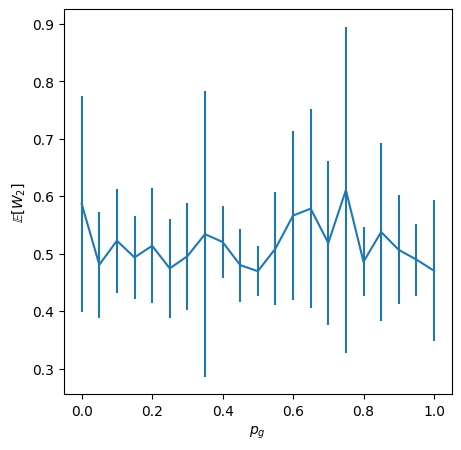

In [22]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
data = pd.read_csv('../data/w2_data/w2.csv')
n = int(len(data) / n_reps)
mu, sigma = np.zeros(n), np.zeros(n)
P_g = np.linspace(0, 100, 21, endpoint=True)/100.
for i, p_g in enumerate(P_g):
    d = data[data['p_g'] == p_g]["w2"] 
    mu[i], sigma[i] = d.mean(), d.std()
ax.errorbar(P_g, mu, sigma)
ax.set_xlabel(r"$p_g$")
ax.set_ylabel(r"$\mathbb{E}[W_2]$")
plt.savefig("../data/plots/W_2_vs_p_g.png", bbox_inches="tight", dpi=300)